# VR CO2 Study - Data processing

This notebook does the following:

1. x
2. y
3. z

Input: input
Output: output

In [45]:
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [75]:
# File containing features for entire segments
segment_features_file = 'D:\\co2-study\\temp\\segment_features.csv'
segment_features = pd.read_csv(segment_features_file, index_col=0)

# File containing features for windows of data
windowed_features_file = 'D:\\co2-study\\temp\\windowed_features.csv'
windowed_features = pd.read_csv(windowed_features_file, index_col=0)

In [121]:
# Filter the data for 'air' and 'co2' conditions with 'gas_inhalation' segment
gas_inhalation_segments = segment_features[(segment_features['Condition'].isin(['AIR', 'CO2'])) & (segment_features['Segment'] == 'gas_inhalation')]
gas_inhalation_windows = windowed_features[(windowed_features['Condition'].isin(['AIR', 'CO2'])) & (windowed_features['Segment'] == 'gas_inhalation')]

gas_inhalation_segments['pupil_size_combined'] = (gas_inhalation_segments['VerboseData.Left.PupilDiameterMm_mean'] + gas_inhalation_segments['VerboseData.Right.PupilDiameterMm_mean']) / 2
gas_inhalation_windows['pupil_size_combined'] = (gas_inhalation_windows['VerboseData.Left.PupilDiameterMm_mean'] + gas_inhalation_windows['VerboseData.Right.PupilDiameterMm_mean']) / 2


# add window index for each participant/condition
window_index = pd.DataFrame({'window_index': gas_inhalation_windows.groupby(['participant_number', 'Condition']).cumcount()})
gas_inhalation_windows.insert(3, 'window_index', window_index['window_index'])

C:\Users\m\AppData\Local\Temp\ipykernel_32180\2212506012.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gas_inhalation_segments['pupil_size_combined'] = (gas_inhalation_segments['VerboseData.Left.PupilDiameterMm_mean'] + gas_inhalation_segments['VerboseData.Right.PupilDiameterMm_mean']) / 2
C:\Users\m\AppData\Local\Temp\ipykernel_32180\2212506012.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gas_inhalation_windows['pupil_size_combined'] = (gas_inhalation_windows['VerboseData.Left.PupilDiameterMm_

# GSR


In [77]:
# GSR
gsr_data_segments = gas_inhalation_segments.filter(regex=r'^(participant_number|Condition|Segment|Biopac_GSR_)').reset_index(drop=True)
gsr_air_segments = gsr_data_segments[gsr_data_segments['Condition']=='AIR']
gsr_co2_segments = gsr_data_segments[gsr_data_segments['Condition']=='CO2']

gsr_data_windows = windowed_features.filter(regex=r'^(participant_number|Condition|Segment|Biopac_GSR_)').reset_index(drop=True)
gsr_air_windows = gsr_data_windows[gsr_data_windows['Condition']=='AIR']
gsr_co2_windows = gsr_data_windows[gsr_data_windows['Condition']=='CO2']

In [78]:
# Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(gsr_air_segments['Biopac_GSR_mean'])
print("GSR Mean - AIR:")
print("Shapiro-Wilk Test - Statistic:", shapiro_test.statistic)
print("Shapiro-Wilk Test - p-value:", shapiro_test.pvalue)

print("GSR Mean - CO2:")
shapiro_test = stats.shapiro(gsr_co2_segments['Biopac_GSR_mean'])
print("Shapiro-Wilk Test - Statistic:", shapiro_test.statistic)
print("Shapiro-Wilk Test - p-value:", shapiro_test.pvalue)

# GSR data is not normally disributed but due to sample size 50+, it is acceptable to run paired t test.

# Perform the paired t-test
t_statistic, p_value = stats.ttest_rel(gsr_air_segments['Biopac_GSR_mean'], gsr_co2_segments['Biopac_GSR_mean'])
print(f"T-statistic: {t_statistic:.3f}")
print(f"P-value: {p_value:.3f}")

GSR Mean - AIR:
Shapiro-Wilk Test - Statistic: 0.9129968881607056
Shapiro-Wilk Test - p-value: 0.001176520367152989
GSR Mean - CO2:
Shapiro-Wilk Test - Statistic: 0.9002663493156433
Shapiro-Wilk Test - p-value: 0.0004292708181310445
T-statistic: -8.122
P-value: 0.000


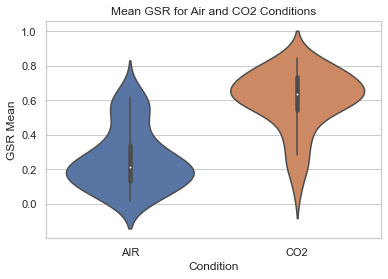

In [79]:
# Create the violin plot
sns.violinplot(x='Condition', y='Biopac_GSR_mean', data=gsr_data_segments)

# Customize plot titles and labels
sns.set(style='whitegrid')
plt.title('Mean GSR for Air and CO2 Conditions')
plt.xlabel('Condition')
plt.ylabel('GSR Mean')

# Display the plot
plt.show()

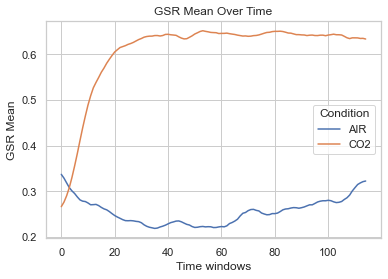

In [80]:
# Group the data by participant and condition, and assign a window index
#gas_inhalation_windows['window_index'].max()
mean_gsr = gas_inhalation_windows.groupby(['Condition', 'window_index'])['Biopac_GSR_mean'].mean().reset_index()
mean_gsr['condition_index'] = mean_gsr.groupby('Condition').cumcount()
# Set the plot style
sns.set(style='whitegrid')

# Plot the line plot
sns.lineplot(x=mean_gsr['condition_index'], y='Biopac_GSR_mean', hue='Condition', data=mean_gsr)

# Customize plot titles and labels
plt.title('GSR Mean Over Time')
plt.xlabel('Time windows')
plt.ylabel('GSR Mean')

# Display the plot
plt.show()

# RSP


In [81]:
# RSP
rsp_data_segments = gas_inhalation_segments.filter(regex=r'^(participant_number|Condition|Segment|Biopac_RSP_|RSP_)').reset_index(drop=True)
rsp_air_segments = rsp_data_segments[rsp_data_segments['Condition']=='AIR']
rsp_co2_segments = rsp_data_segments[rsp_data_segments['Condition']=='CO2']

rsp_data_windows = windowed_features.filter(regex=r'^(participant_number|Condition|Segment|Biopac_RSP_|RSP_)').reset_index(drop=True)
rsp_air_windows = rsp_data_windows[rsp_data_windows['Condition']=='AIR']
rsp_co2_windows = rsp_data_windows[rsp_data_windows['Condition']=='CO2']

In [82]:
# Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(rsp_air_segments['RSP_Rate_Mean'])
print("RSP Mean - AIR:")
print("Shapiro-Wilk Test - Statistic:", shapiro_test.statistic)
print("Shapiro-Wilk Test - p-value:", shapiro_test.pvalue)

print("RSP Mean - CO2:")
shapiro_test = stats.shapiro(rsp_co2_segments['RSP_Rate_Mean'])
print("Shapiro-Wilk Test - Statistic:", shapiro_test.statistic)
print("Shapiro-Wilk Test - p-value:", shapiro_test.pvalue)

# RSP data is not normally disributed but due to sample size 50+, it is acceptable to run paired t test.

# Perform the paired t-test
t_statistic, p_value = stats.ttest_rel(rsp_air_segments['RSP_Rate_Mean'], rsp_co2_segments['RSP_Rate_Mean'])
print(f"T-statistic: {t_statistic:.3f}")
print(f"P-value: {p_value:.3f}")

RSP Mean - AIR:
Shapiro-Wilk Test - Statistic: 0.9729321599006653
Shapiro-Wilk Test - p-value: 0.291618287563324
RSP Mean - CO2:
Shapiro-Wilk Test - Statistic: 0.9631925821304321
Shapiro-Wilk Test - p-value: 0.11412087827920914
T-statistic: -13.831
P-value: 0.000


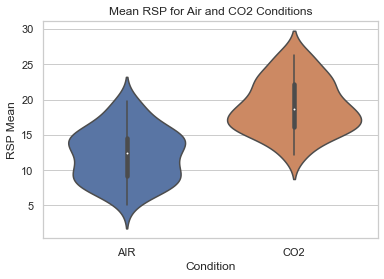

In [84]:
# Create the violin plot
sns.violinplot(x='Condition', y='RSP_Rate_Mean', data=rsp_data_segments)

# Customize plot titles and labels
sns.set(style='whitegrid')
plt.title('Mean RSP for Air and CO2 Conditions')
plt.xlabel('Condition')
plt.ylabel('RSP Mean')

# Display the plot
plt.show()

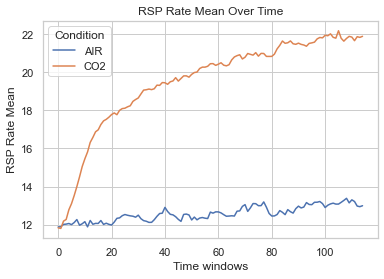

In [87]:
# Group the data by participant and condition, and assign a window index
#gas_inhalation_windows['window_index'].max()
mean_rsp = gas_inhalation_windows.groupby(['Condition', 'window_index'])['RSP_Rate_Mean'].mean().reset_index()
mean_rsp['condition_index'] = mean_rsp.groupby('Condition').cumcount()
# Set the plot style
sns.set(style='whitegrid')

# Plot the line plot
sns.lineplot(x=mean_rsp['condition_index'], y='RSP_Rate_Mean', hue='Condition', data=mean_rsp)

# Customize plot titles and labels
plt.title('RSP Rate Mean Over Time')
plt.xlabel('Time windows')
plt.ylabel('RSP Rate Mean')

# Display the plot
plt.show()

# HR


In [98]:
# RSP
hr_data_segments = gas_inhalation_segments.filter(regex=r'^(participant_number|Condition|Segment|PPG_|HRV_|HeartRate/Average_mean)').reset_index(drop=True)
hr_air_segments = hr_data_segments[hr_data_segments['Condition']=='AIR']
hr_co2_segments = hr_data_segments[hr_data_segments['Condition']=='CO2']

hr_data_windows = windowed_features.filter(regex=r'^(participant_number|Condition|Segment|PPG_|HRV_|HeartRate/Average_mean)').reset_index(drop=True)
hr_air_windows = hr_data_windows[hr_data_windows['Condition']=='AIR']
hr_co2_windows = hr_data_windows[hr_data_windows['Condition']=='CO2']

In [101]:
# Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(hr_air_segments['HeartRate/Average_mean'])
print("HR Mean - AIR:")
print("Shapiro-Wilk Test - Statistic:", shapiro_test.statistic)
print("Shapiro-Wilk Test - p-value:", shapiro_test.pvalue)

print("HR Mean - CO2:")
shapiro_test = stats.shapiro(hr_co2_segments['HeartRate/Average_mean'])
print("Shapiro-Wilk Test - Statistic:", shapiro_test.statistic)
print("Shapiro-Wilk Test - p-value:", shapiro_test.pvalue)

# HR data is not normally disributed but due to sample size 50+, it is acceptable to run paired t test.

# Perform the paired t-test
t_statistic, p_value = stats.ttest_rel(hr_air_segments['HeartRate/Average_mean'], hr_co2_segments['HeartRate/Average_mean'])
print(f"T-statistic: {t_statistic:.3f}")
print(f"P-value: {p_value:.3f}")

HR Mean - AIR:
Shapiro-Wilk Test - Statistic: 0.9561042189598083
Shapiro-Wilk Test - p-value: 0.0569465197622776
HR Mean - CO2:
Shapiro-Wilk Test - Statistic: 0.973604142665863
Shapiro-Wilk Test - p-value: 0.3103034794330597
T-statistic: -8.155
P-value: 0.000


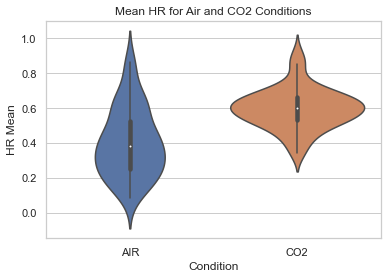

In [111]:
# Create the violin plot
sns.violinplot(x='Condition', y='HeartRate/Average_mean', data=hr_data_segments)

# Customize plot titles and labels
sns.set(style='whitegrid')
plt.title('Mean HR for Air and CO2 Conditions')
plt.xlabel('Condition')
plt.ylabel('HR Mean')

# Display the plot
plt.show()

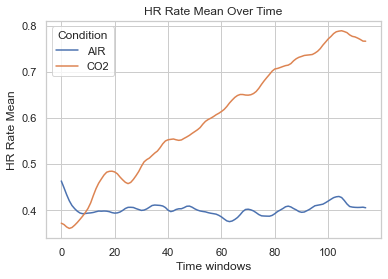

In [105]:
# Group the data by participant and condition, and assign a window index
#gas_inhalation_windows['window_index'].max()
mean_hr = gas_inhalation_windows.groupby(['Condition', 'window_index'])['HeartRate/Average_mean'].mean().reset_index()
mean_hr['condition_index'] = mean_hr.groupby('Condition').cumcount()
# Set the plot style
sns.set(style='whitegrid')

# Plot the line plot
sns.lineplot(x=mean_hr['condition_index'], y='HeartRate/Average_mean', hue='Condition', data=mean_hr)

# Customize plot titles and labels
plt.title('HR Rate Mean Over Time')
plt.xlabel('Time windows')
plt.ylabel('HR Rate Mean')

# Display the plot
plt.show()

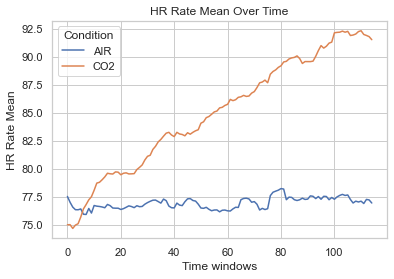

In [100]:
# Group the data by participant and condition, and assign a window index
#gas_inhalation_windows['window_index'].max()
mean_hr = gas_inhalation_windows.groupby(['Condition', 'window_index'])['PPG_Rate_Mean'].mean().reset_index()
mean_hr['condition_index'] = mean_hr.groupby('Condition').cumcount()
# Set the plot style
sns.set(style='whitegrid')

# Plot the line plot
sns.lineplot(x=mean_hr['condition_index'], y='PPG_Rate_Mean', hue='Condition', data=mean_hr)

# Customize plot titles and labels
plt.title('HR Rate Mean Over Time')
plt.xlabel('Time windows')
plt.ylabel('HR Rate Mean')

# Display the plot
plt.show()

# Pupil Size

In [125]:
# Pupil size
pupil_data_segments = gas_inhalation_segments.filter(regex=r'^(participant_number|Condition|Segment|VerboseData.|pupil_)').reset_index(drop=True)
#pupil_data_segments['pupil_size_combined'] = (pupil_data_segments['VerboseData.Left.PupilDiameterMm_mean'] + pupil_data_segments['VerboseData.Right.PupilDiameterMm_mean']) / 2

pupil_air_segments = pupil_data_segments[pupil_data_segments['Condition']=='AIR']
pupil_co2_segments = pupil_data_segments[pupil_data_segments['Condition']=='CO2']

pupil_data_windows = windowed_features.filter(regex=r'^(participant_number|Condition|Segment|VerboseData.|pupil_)').reset_index(drop=True)
pupil_air_windows = pupil_data_windows[pupil_data_windows['Condition']=='AIR']
pupil_co2_windows = pupil_data_windows[pupil_data_windows['Condition']=='CO2']

In [126]:
# Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(pupil_air_segments['pupil_size_combined'])
print("Combined Pupil Size Mean - AIR:")
print("Shapiro-Wilk Test - Statistic:", shapiro_test.statistic)
print("Shapiro-Wilk Test - p-value:", shapiro_test.pvalue)

print("Combined Pupil Size Mean - CO2:")
shapiro_test = stats.shapiro(pupil_co2_segments['pupil_size_combined'])
print("Shapiro-Wilk Test - Statistic:", shapiro_test.statistic)
print("Shapiro-Wilk Test - p-value:", shapiro_test.pvalue)

# HR data is not normally disributed but due to sample size 50+, it is acceptable to run paired t test.

# Perform the paired t-test
t_statistic, p_value = stats.ttest_rel(pupil_air_segments['pupil_size_combined'], pupil_co2_segments['pupil_size_combined'])
print(f"T-statistic: {t_statistic:.3f}")
print(f"P-value: {p_value:.3f}")

Combined Pupil Size Mean - AIR:
Shapiro-Wilk Test - Statistic: 0.9559202790260315
Shapiro-Wilk Test - p-value: 0.05593271553516388
Combined Pupil Size Mean - CO2:
Shapiro-Wilk Test - Statistic: 0.9762814044952393
Shapiro-Wilk Test - p-value: 0.3948725461959839
T-statistic: -1.934
P-value: 0.059


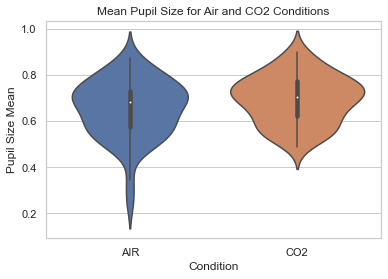

In [130]:
# Create the violin plot
sns.violinplot(x='Condition', y='pupil_size_combined', data=pupil_data_segments)

# Customize plot titles and labels
sns.set(style='whitegrid')
plt.title('Mean Pupil Size for Air and CO2 Conditions')
plt.xlabel('Condition')
plt.ylabel('Pupil Size Mean')

# Display the plot
plt.show()

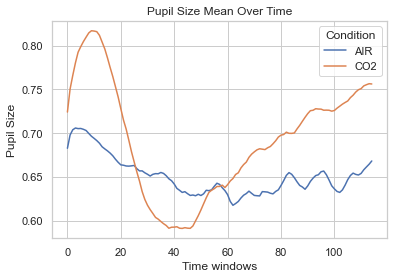

In [129]:
# Group the data by participant and condition, and assign a window index
#gas_inhalation_windows['window_index'].max()
mean_hr = gas_inhalation_windows.groupby(['Condition', 'window_index'])['pupil_size_combined'].mean().reset_index()
mean_hr['condition_index'] = mean_hr.groupby('Condition').cumcount()
# Set the plot style
sns.set(style='whitegrid')

# Plot the line plot
sns.lineplot(x=mean_hr['condition_index'], y='pupil_size_combined', hue='Condition', data=mean_hr)

# Customize plot titles and labels
plt.title('Pupil Size Mean Over Time')
plt.xlabel('Time windows')
plt.ylabel('Pupil Size')

# Display the plot
plt.show()

# EMG Contact

In [131]:
# Pupil size
contact_data_segments = gas_inhalation_segments.filter(regex=r'^(participant_number|Condition|Segment|Emg/Contact)').reset_index(drop=True)

contact_air_segments = contact_data_segments[contact_data_segments['Condition']=='AIR']
contact_co2_segments = contact_data_segments[contact_data_segments['Condition']=='CO2']

contact_data_windows = windowed_features.filter(regex=r'^(participant_number|Condition|Segment|Emg/Contact)').reset_index(drop=True)
contact_air_windows = contact_data_windows[contact_data_windows['Condition']=='AIR']
contact_co2_windows = contact_data_windows[contact_data_windows['Condition']=='CO2']

In [ ]:
# Shapiro-Wilk test for normality


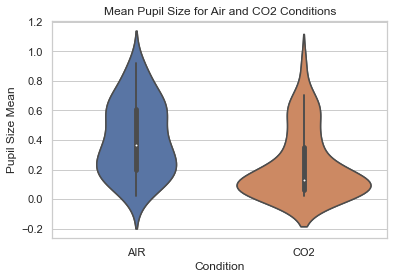

In [135]:
# Create the violin plot
sns.violinplot(x='Condition', y='Emg/Contact[RightOrbicularis]_mean', data=contact_data_segments)

# Customize plot titles and labels
sns.set(style='whitegrid')
plt.title('Mean Pupil Size for Air and CO2 Conditions')
plt.xlabel('Condition')
plt.ylabel('Pupil Size Mean')

# Display the plot
plt.show()

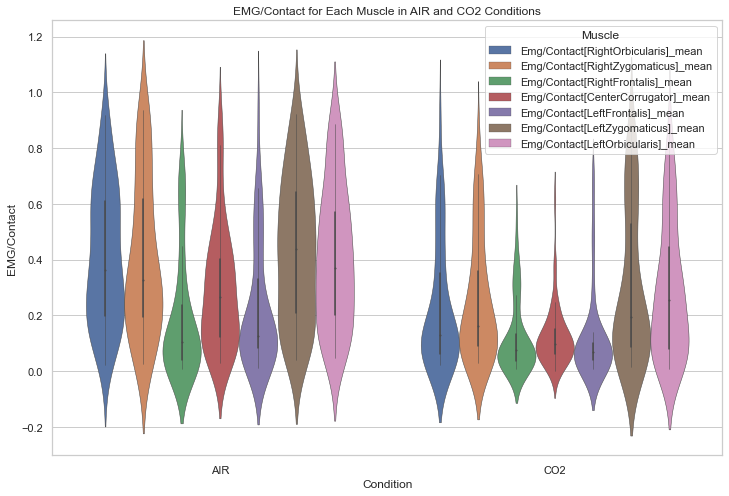

In [160]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the dataframe for 'AIR' and 'CO2' conditions
air_co2_data = contact_data_segments.copy()

# Melt the dataframe to convert separate columns for each muscle into a single column
melted_data = air_co2_data.melt(id_vars=['Condition', 'Segment'], value_vars=['Emg/Contact[RightOrbicularis]_mean', 'Emg/Contact[RightZygomaticus]_mean', 'Emg/Contact[RightFrontalis]_mean', 'Emg/Contact[CenterCorrugator]_mean', 'Emg/Contact[LeftFrontalis]_mean', 'Emg/Contact[LeftZygomaticus]_mean', 'Emg/Contact[LeftOrbicularis]_mean'], var_name='Muscle', value_name='Emg_Contact')

# Define the order of the muscles for plotting
muscle_order = ['RightOrbicularis', 'RightZygomaticus', 'RightFrontalis', 'CenterCorrugator', 'LeftFrontalis', 'LeftZygomaticus', 'LeftOrbicularis']

# Create the violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(x='Condition', y='Emg_Contact', hue='Muscle', data=melted_data, scale='width', linewidth=0.5)


# Customize the plot
plt.title('EMG/Contact for Each Muscle in AIR and CO2 Conditions')
plt.xlabel('Condition')
plt.ylabel('EMG/Contact')
plt.legend(title='Muscle')

# Show the plot
plt.show()


C:\Users\m\AppData\Local\Temp\ipykernel_32180\1549215360.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_contact = gas_inhalation_windows.groupby(['Condition', 'window_index'])['Emg/Contact[RightOrbicularis]_mean', 'Emg/Contact[RightZygomaticus]_mean', 'Emg/Contact[RightFrontalis]_mean', 'Emg/Contact[CenterCorrugator]_mean', 'Emg/Contact[LeftFrontalis]_mean', 'Emg/Contact[LeftZygomaticus]_mean', 'Emg/Contact[LeftOrbicularis]_mean'].mean().reset_index()


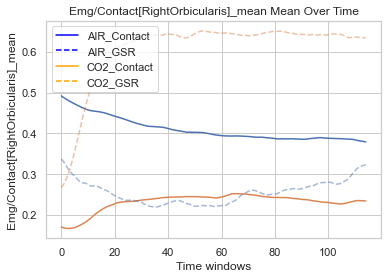

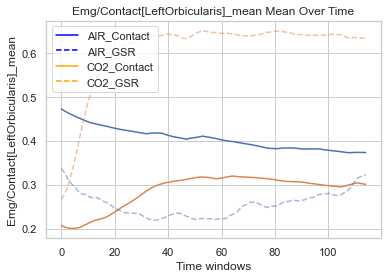

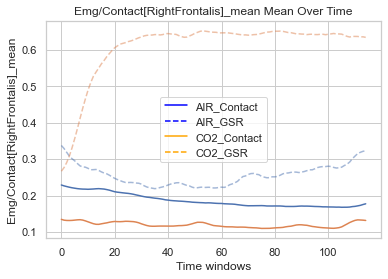

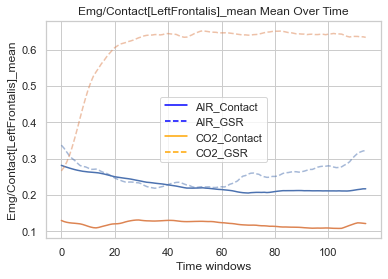

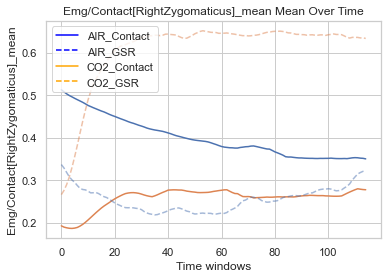

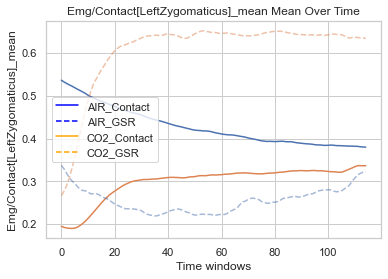

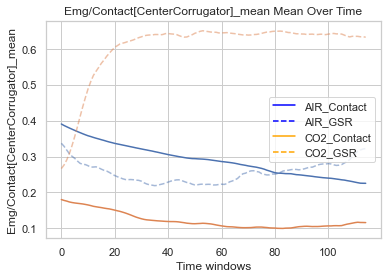

In [200]:
# Group the data by participant and condition, and assign a window index
#gas_inhalation_windows['window_index'].max()
mean_contact = gas_inhalation_windows.groupby(['Condition', 'window_index'])['Emg/Contact[RightOrbicularis]_mean', 'Emg/Contact[RightZygomaticus]_mean', 'Emg/Contact[RightFrontalis]_mean', 'Emg/Contact[CenterCorrugator]_mean', 'Emg/Contact[LeftFrontalis]_mean', 'Emg/Contact[LeftZygomaticus]_mean', 'Emg/Contact[LeftOrbicularis]_mean'].mean().reset_index()
mean_contact['condition_index'] = mean_contact.groupby('Condition').cumcount()

# Set the plot style
sns.set(style='whitegrid')

# RightOrbicularis

# Plot the line plot
sns.lineplot(x=mean_contact['condition_index'], y='Emg/Contact[RightOrbicularis]_mean', hue='Condition', data=mean_contact)
#sns.lineplot(x=mean_contact['condition_index'], y='Emg/Contact[LeftOrbicularis]_mean', hue='Condition', data=mean_contact)
sns.lineplot(x=mean_gsr['condition_index'], y='Biopac_GSR_mean', hue='Condition', data=mean_gsr, linestyle='--', alpha=0.5)
import matplotlib.lines as mlines

# Get the current axes
ax = plt.gca()

# Create custom legend handles and labels
solid_line = mlines.Line2D([], [], color='blue', linestyle='-', label='AIR_Contact')
dotted_line = mlines.Line2D([], [], color='blue', linestyle='--', label='AIR_GSR')
solid_line2 = mlines.Line2D([], [], color='orange', linestyle='-', label='CO2_Contact')
dotted_line2 = mlines.Line2D([], [], color='orange', linestyle='--', label='CO2_GSR')

# Set the legend handles and labels
handles = [solid_line, dotted_line, solid_line2, dotted_line2]
labels = ['AIR_Contact', 'AIR_GSR', 'CO2_Contact', 'CO2_GSR']
ax.legend(handles, labels)

# Customize plot titles and labels
plt.title('Emg/Contact[RightOrbicularis]_mean Mean Over Time')
plt.xlabel('Time windows')
plt.ylabel('Emg/Contact[RightOrbicularis]_mean')

# Display the plot
plt.show()


# LeftOrbicularis

# Plot the line plot
sns.lineplot(x=mean_contact['condition_index'], y='Emg/Contact[LeftOrbicularis]_mean', hue='Condition', data=mean_contact)
#sns.lineplot(x=mean_contact['condition_index'], y='Emg/Contact[LeftOrbicularis]_mean', hue='Condition', data=mean_contact)
sns.lineplot(x=mean_gsr['condition_index'], y='Biopac_GSR_mean', hue='Condition', data=mean_gsr, linestyle='--', alpha=0.5)
import matplotlib.lines as mlines

# Get the current axes
ax = plt.gca()

# Create custom legend handles and labels
solid_line = mlines.Line2D([], [], color='blue', linestyle='-', label='AIR_Contact')
dotted_line = mlines.Line2D([], [], color='blue', linestyle='--', label='AIR_GSR')
solid_line2 = mlines.Line2D([], [], color='orange', linestyle='-', label='CO2_Contact')
dotted_line2 = mlines.Line2D([], [], color='orange', linestyle='--', label='CO2_GSR')

# Set the legend handles and labels
handles = [solid_line, dotted_line, solid_line2, dotted_line2]
labels = ['AIR_Contact', 'AIR_GSR', 'CO2_Contact', 'CO2_GSR']
ax.legend(handles, labels)

# Customize plot titles and labels
plt.title('Emg/Contact[LeftOrbicularis]_mean Mean Over Time')
plt.xlabel('Time windows')
plt.ylabel('Emg/Contact[LeftOrbicularis]_mean')

# Display the plot
plt.show()

# RightFrontalis

# Plot the line plot
sns.lineplot(x=mean_contact['condition_index'], y='Emg/Contact[RightFrontalis]_mean', hue='Condition', data=mean_contact)
#sns.lineplot(x=mean_contact['condition_index'], y='Emg/Contact[RightFrontalis]_mean', hue='Condition', data=mean_contact)
sns.lineplot(x=mean_gsr['condition_index'], y='Biopac_GSR_mean', hue='Condition', data=mean_gsr, linestyle='--', alpha=0.5)
import matplotlib.lines as mlines

# Get the current axes
ax = plt.gca()

# Create custom legend handles and labels
solid_line = mlines.Line2D([], [], color='blue', linestyle='-', label='AIR_Contact')
dotted_line = mlines.Line2D([], [], color='blue', linestyle='--', label='AIR_GSR')
solid_line2 = mlines.Line2D([], [], color='orange', linestyle='-', label='CO2_Contact')
dotted_line2 = mlines.Line2D([], [], color='orange', linestyle='--', label='CO2_GSR')

# Set the legend handles and labels
handles = [solid_line, dotted_line, solid_line2, dotted_line2]
labels = ['AIR_Contact', 'AIR_GSR', 'CO2_Contact', 'CO2_GSR']
ax.legend(handles, labels)

# Customize plot titles and labels
plt.title('Emg/Contact[RightFrontalis]_mean Mean Over Time')
plt.xlabel('Time windows')
plt.ylabel('Emg/Contact[RightFrontalis]_mean')

# Display the plot
plt.show()

# LeftFrontalis

# Plot the line plot
sns.lineplot(x=mean_contact['condition_index'], y='Emg/Contact[LeftFrontalis]_mean', hue='Condition', data=mean_contact)
#sns.lineplot(x=mean_contact['condition_index'], y='Emg/Contact[LeftFrontalis]_mean', hue='Condition', data=mean_contact)
sns.lineplot(x=mean_gsr['condition_index'], y='Biopac_GSR_mean', hue='Condition', data=mean_gsr, linestyle='--', alpha=0.5)
import matplotlib.lines as mlines

# Get the current axes
ax = plt.gca()

# Create custom legend handles and labels
solid_line = mlines.Line2D([], [], color='blue', linestyle='-', label='AIR_Contact')
dotted_line = mlines.Line2D([], [], color='blue', linestyle='--', label='AIR_GSR')
solid_line2 = mlines.Line2D([], [], color='orange', linestyle='-', label='CO2_Contact')
dotted_line2 = mlines.Line2D([], [], color='orange', linestyle='--', label='CO2_GSR')

# Set the legend handles and labels
handles = [solid_line, dotted_line, solid_line2, dotted_line2]
labels = ['AIR_Contact', 'AIR_GSR', 'CO2_Contact', 'CO2_GSR']
ax.legend(handles, labels)

# Customize plot titles and labels
plt.title('Emg/Contact[LeftFrontalis]_mean Mean Over Time')
plt.xlabel('Time windows')
plt.ylabel('Emg/Contact[LeftFrontalis]_mean')

# Display the plot
plt.show()

# RightZygomaticus

# Plot the line plot
sns.lineplot(x=mean_contact['condition_index'], y='Emg/Contact[RightZygomaticus]_mean', hue='Condition', data=mean_contact)
#sns.lineplot(x=mean_contact['condition_index'], y='Emg/Contact[RightZygomaticus]_mean', hue='Condition', data=mean_contact)
sns.lineplot(x=mean_gsr['condition_index'], y='Biopac_GSR_mean', hue='Condition', data=mean_gsr, linestyle='--', alpha=0.5)
import matplotlib.lines as mlines

# Get the current axes
ax = plt.gca()

# Create custom legend handles and labels
solid_line = mlines.Line2D([], [], color='blue', linestyle='-', label='AIR_Contact')
dotted_line = mlines.Line2D([], [], color='blue', linestyle='--', label='AIR_GSR')
solid_line2 = mlines.Line2D([], [], color='orange', linestyle='-', label='CO2_Contact')
dotted_line2 = mlines.Line2D([], [], color='orange', linestyle='--', label='CO2_GSR')

# Set the legend handles and labels
handles = [solid_line, dotted_line, solid_line2, dotted_line2]
labels = ['AIR_Contact', 'AIR_GSR', 'CO2_Contact', 'CO2_GSR']
ax.legend(handles, labels)

# Customize plot titles and labels
plt.title('Emg/Contact[RightZygomaticus]_mean Mean Over Time')
plt.xlabel('Time windows')
plt.ylabel('Emg/Contact[RightZygomaticus]_mean')

# Display the plot
plt.show()

# LeftZygomaticus

# Plot the line plot
sns.lineplot(x=mean_contact['condition_index'], y='Emg/Contact[LeftZygomaticus]_mean', hue='Condition', data=mean_contact)
#sns.lineplot(x=mean_contact['condition_index'], y='Emg/Contact[LeftZygomaticus]_mean', hue='Condition', data=mean_contact)
sns.lineplot(x=mean_gsr['condition_index'], y='Biopac_GSR_mean', hue='Condition', data=mean_gsr, linestyle='--', alpha=0.5)
import matplotlib.lines as mlines

# Get the current axes
ax = plt.gca()

# Create custom legend handles and labels
solid_line = mlines.Line2D([], [], color='blue', linestyle='-', label='AIR_Contact')
dotted_line = mlines.Line2D([], [], color='blue', linestyle='--', label='AIR_GSR')
solid_line2 = mlines.Line2D([], [], color='orange', linestyle='-', label='CO2_Contact')
dotted_line2 = mlines.Line2D([], [], color='orange', linestyle='--', label='CO2_GSR')

# Set the legend handles and labels
handles = [solid_line, dotted_line, solid_line2, dotted_line2]
labels = ['AIR_Contact', 'AIR_GSR', 'CO2_Contact', 'CO2_GSR']
ax.legend(handles, labels)

# Customize plot titles and labels
plt.title('Emg/Contact[LeftZygomaticus]_mean Mean Over Time')
plt.xlabel('Time windows')
plt.ylabel('Emg/Contact[LeftZygomaticus]_mean')

# Display the plot
plt.show()

# CenterCorrugator

# Plot the line plot
sns.lineplot(x=mean_contact['condition_index'], y='Emg/Contact[CenterCorrugator]_mean', hue='Condition', data=mean_contact)
#sns.lineplot(x=mean_contact['condition_index'], y='Emg/Contact[CenterCorrugator]_mean', hue='Condition', data=mean_contact)
sns.lineplot(x=mean_gsr['condition_index'], y='Biopac_GSR_mean', hue='Condition', data=mean_gsr, linestyle='--', alpha=0.5)
import matplotlib.lines as mlines

# Get the current axes
ax = plt.gca()

# Create custom legend handles and labels
solid_line = mlines.Line2D([], [], color='blue', linestyle='-', label='AIR_Contact')
dotted_line = mlines.Line2D([], [], color='blue', linestyle='--', label='AIR_GSR')
solid_line2 = mlines.Line2D([], [], color='orange', linestyle='-', label='CO2_Contact')
dotted_line2 = mlines.Line2D([], [], color='orange', linestyle='--', label='CO2_GSR')

# Set the legend handles and labels
handles = [solid_line, dotted_line, solid_line2, dotted_line2]
labels = ['AIR_Contact', 'AIR_GSR', 'CO2_Contact', 'CO2_GSR']
ax.legend(handles, labels)

# Customize plot titles and labels
plt.title('Emg/Contact[CenterCorrugator]_mean Mean Over Time')
plt.xlabel('Time windows')
plt.ylabel('Emg/Contact[CenterCorrugator]_mean')

# Display the plot
plt.show()